In [5]:
using Pkg
Pkg.activate(".")
using SimilaritySearch, UMAP, LinearAlgebra, JLD2, CSV, DataFrames, TextSearch, Glob, StatsBase, Plots


  Activating project at `~/Research/RegionalSpanish/notebooks`


In [6]:
edir = "../data/SpanishLang/embeddings"
k = 33
common = CSV.read("../data/SpanishLang/common-tokens-per-region.tsv.gz", DataFrame, delim='\t')
subset!(common, :n_regions => n -> n .> 10)
cclist = split(first(subset(common, :n_regions => n -> n .== 26).country_codes), ',')
@info sort!(cclist)

┌ Info: SubString{String}["ALL", "AR", "BO", "BR", "CA", "CL", "CO", "CR", "CU", "DO", "EC", "ES", "FR", "GB", "GQ", "GT", "HN", "MX", "NI", "PA", "PE", "PR", "PY", "SV", "US", "UY", "VE"]
└ @ Main In[6]:6


In [7]:

function encode_model(vocab, umapmodel)
   #  ivocab = Dict(token => i for (i, token) in enumerate(vocab))
    obj = Dict{Symbol,Dict{Symbol,Float64}}()
    for (i, (idcol, distcol)) in enumerate(zip(eachcol(umapmodel.knns), eachcol(umapmodel.dists)))
        v = Dict(vocab[idcol[i]] => distcol[i] for i in eachindex(idcol, distcol))
        normalize!(v)
        obj[vocab[i]] = v
    end

    obj
end

struct SumDist <: SemiMetric
end


function SimilaritySearch.evaluate(D::SumDist, model0, model1)
    s = 0.0
    if length(model1) < length(model0)
        model0, model1 = model1, model0
    end

    for (t, m0) in model0
        m1 = get(model1, t, nothing)
        if m1 === nothing
            continue
        end

        s += dot(m0, m1)
    end

    1.0 - s / length(model1)
end

#=
function SimilaritySearch.evaluate(D::SumDist, model0, model1)
    s = 0.0
    for t in D.tokens
        m0 = get(model0, t, nothing)
        if m0 === nothing
            s += D.missing_cost
            continue
        end

        m1 = get(model1, t, nothing)
        if m1 === nothing
            s += D.missing_cost
            continue
        end

        s += evaluate(NormalizedCosineDistance(), m0, m1)
    end

    s / (length(D.tokens) * D.missing_cost)
end
=#

In [8]:
all, vocab = load(joinpath(edir, "umap+index-common-tokens-ALL.k=$k.jld2"), "U2", "vocab")
dist = SumDist()


SumDist()

In [9]:
db = []

for modelname in sort(glob(joinpath(edir, "umap+index-common-tokens-*.k=$k.jld2")))
    model_, vocab_ = load(modelname, "U2", "vocab")
    push!(db, encode_model(Symbol.(vocab_), model_))
end
#index = ExhaustiveSearch(db=)

In [10]:
n = length(cclist)
A = Matrix{Float64}(undef, n, n)

for (i, cc) in enumerate(cclist)
    u = db[i]
    A[i, i] = 0.0
    @time for j in i+1:n
        v = db[j]
        A[j, i] = A[i, j] = evaluate(dist, u, v)        
    end
end

  4.521248 seconds (109.78 k allocations: 5.811 MiB, 1.50% compilation time)
  4.206952 seconds (51 allocations: 1.203 KiB)
  1.888995 seconds (49 allocations: 1.156 KiB)
  2.700398 seconds (47 allocations: 1.109 KiB)
  2.285496 seconds (45 allocations: 1.062 KiB)
  3.588296 seconds (43 allocations: 1.016 KiB)
  3.348599 seconds (41 allocations: 992 bytes)
  2.562800 seconds (39 allocations: 944 bytes)
  0.598970 seconds (37 allocations: 896 bytes)
  2.371874 seconds (35 allocations: 848 bytes)
  2.404777 seconds (33 allocations: 800 bytes)
  2.522041 seconds (31 allocations: 752 bytes)
  1.341825 seconds (29 allocations: 704 bytes)
  1.433317 seconds (27 allocations: 656 bytes)
  0.020857 seconds (25 allocations: 608 bytes)
  1.536969 seconds (23 allocations: 560 bytes)
  1.024466 seconds (21 allocations: 512 bytes)
  1.634275 seconds (19 allocations: 464 bytes)
  0.849465 seconds (17 allocations: 416 bytes)
  1.064306 seconds (15 allocations: 368 bytes)
  1.051216 seconds (13 allocat

In [11]:
min_dist = 0.03
n_neighbors = 3
neg_sample_rate = 5
local_connectivity = 1
# metric = :precomputed

struct PreComputed <: SemiMetric
    A::Matrix{Float64}
end

function SimilaritySearch.evaluate(p::PreComputed, i, j)
    p.A[i, j]
end

index = ExhaustiveSearch(db=VectorDatabase(collect(1:size(A, 1))), dist=PreComputed(A))
#index = ExhaustiveSearch(db=A, dist=L2Distance())
U2 = UMAP_(index, 2; n_neighbors, neg_sample_rate, local_connectivity)
U3 = UMAP_(U2, 3; neg_sample_rate)
nothing

(n, n_neighbors, n_components) = (27, 3, 2)
  0.017201 seconds (300 allocations: 4.688 KiB)
  0.017804 seconds (300 allocations: 4.688 KiB)


*** computing allknn graph
*** computing graph
*** init embedding
*** fit ab / embedding
*** opt embedding


In [12]:
X = U2.embedding
C = U3.embedding
#C .= C .+ 5

for i in (1, 2, 3)
    v = @view C[i, :]
    s = 4 * std(v)
    v .= v ./ s .+ 0.5
    
    for j in eachindex(v)
        v[j] = clamp(v[j],  0, 1)
    end
end

C = [RGB(c...) for c in eachcol(C)]

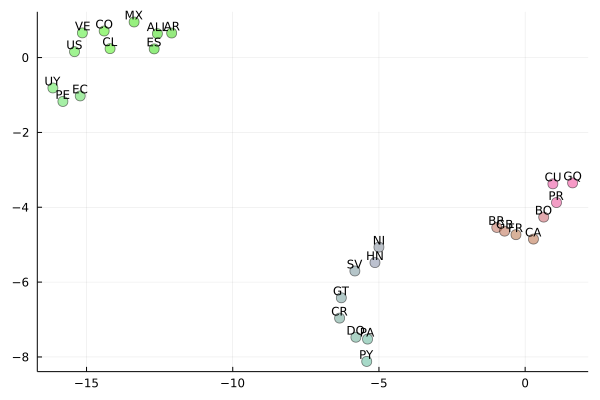

In [13]:

poslist = [:bottom]
scatter(X[1, :], X[2, :], c=C, label="", series_annotations=[text(cc, rand(poslist), 8) for cc in cclist], ms=6, ma=0.5, fa=0.5, la=0.5, alpha=0.5, fmt=:png)
#savefig("../figs/fig-emo-umap.pdf")
#plot!(fmt=:png)



In [14]:
D = Dict(zip(cclist, db))
@show [
evaluate(dist, D["MX"], D["MX"])
evaluate(dist, D["MX"], D["ALL"])
evaluate(dist, D["MX"], D["SV"])
evaluate(dist, D["ES"], D["GQ"])
]

@info D["MX"][:iglesia]
@info D["US"][:iglesia]

[evaluate(dist, D["MX"], D["MX"]); evaluate(dist, D["MX"], D["ALL"]); evaluate(dist, D["MX"], D["SV"]); evaluate(dist, D["ES"], D["GQ"])] = [3.849021101842709e-11, 0.6376721535381715, 0.9032403461418184, 0.9998660530388699]


┌ Info: Dict(:evangelicos => 0.17621584236621857, :eucaristia => 0.17046259343624115, :clero => 0.17600928246974945, :evangelico => 0.18030348420143127, :evangelicas => 0.18243682384490967, :congrego => 0.18656587600708008, :sacerdote => 0.17659971117973328, :religioso => 0.15960830450057983, :⛪ => 0.17873378098011017, :congregaciones => 0.17958737909793854, :apostolicos => 0.1846739798784256, :catolica => 0.10789193212985992, :cristianos => 0.18055343627929688, :religiosos => 0.17738479375839233, :sacerdotal => 0.18456076085567474, :catolico => 0.16612295806407928, :evangelica => 0.18335027992725372, :parroco => 0.17126694321632385, :sacramentos => 0.1858905404806137, :sacerdotes => 0.17506560683250427, :apostolica => 0.15883192420005798, :misa => 0.15502464771270752, :catedral => 0.17554466426372528, :parroquia => 0.18487390875816345, :catolicos => 0.1629718393087387, :catolicas => 0.16526751220226288, :religion => 0.18622905015945435, :cristiana => 0.1816086620092392, :basilica => 0

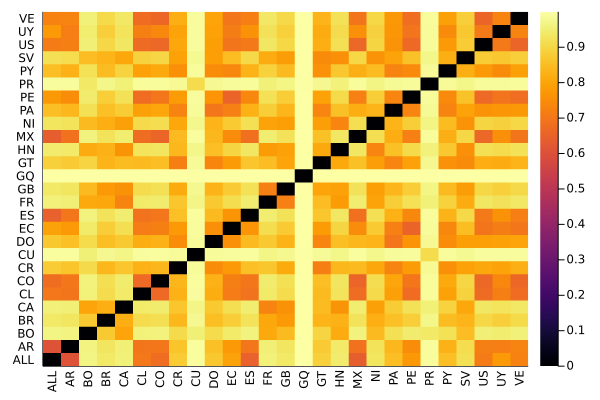

In [15]:
heatmap(cclist, cclist, A, ticks = :all, xrot=90)